<a href="https://colab.research.google.com/github/jacksonlaporta/Automated-News-Article-Categorisation/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Automated News Article Categorisation
==============

***SWE6204 Machine Learning***

**Author:** *Jackson Dalla Porta Alves*

**Student number:** *2303192*

This study applies machine learning techniques to automate the categorisation of news articles using a BBC dataset.

### Load Dependencies

Load all necessary libraries and modules required for the analysis and modeling.


In [ ]:
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from scipy.sparse import vstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.utils import resample
from wordcloud import WordCloud

### Load the dataset

Load the dataset for analysis and preview the first few rows to understand the data structure.


In [ ]:
df = pd.read_csv("./data/BBC News Train.csv")
print(df.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


### Exploratory Data Analysis (EDA)

Perform exploratory data analysis to understand the distribution of categories and check for any missing values.


In [ ]:
# Check the distribution of categories
print(df["Category"].value_counts())

# Check for any missing values
print(df.isnull().sum())

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
ArticleId    0
Text         0
Category     0
dtype: int64


### Preprocess the Text Data

Define the text preprocessing steps including removal of punctuation, tokenization, removal of stopwords, and stemming.


In [ ]:
# Download NLTK punkt and stopwords
nltk.download("punkt")
nltk.download("stopwords")


# Preprocessing function
def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)


# Apply preprocessing
df["processed_text"] = df["Text"].apply(preprocess_text)
print(df["processed_text"].head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jack.dalla.porta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jack.dalla.porta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    worldcom exboss launch defenc lawyer defend fo...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster better funk...
4    enron boss payout eighteen former enron direct...
Name: processed_text, dtype: object


### Word Cloud

Generate word clouds for each category in the dataset to visualize the most frequent words. This provides a visual representation of the text data, helping to quickly grasp the common themes and terms across different news categories.


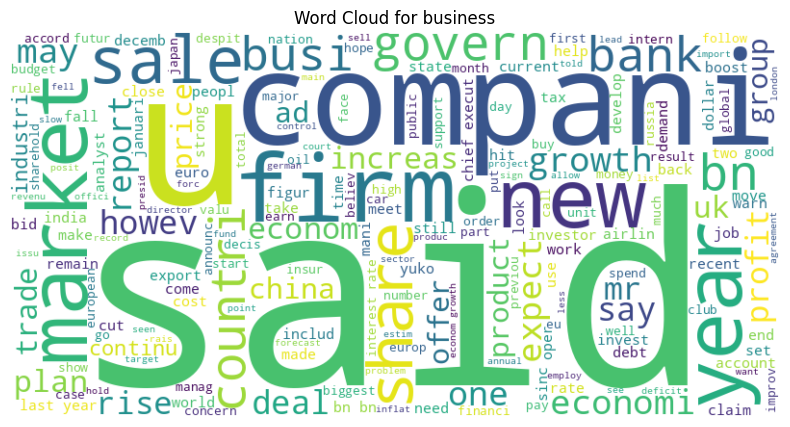

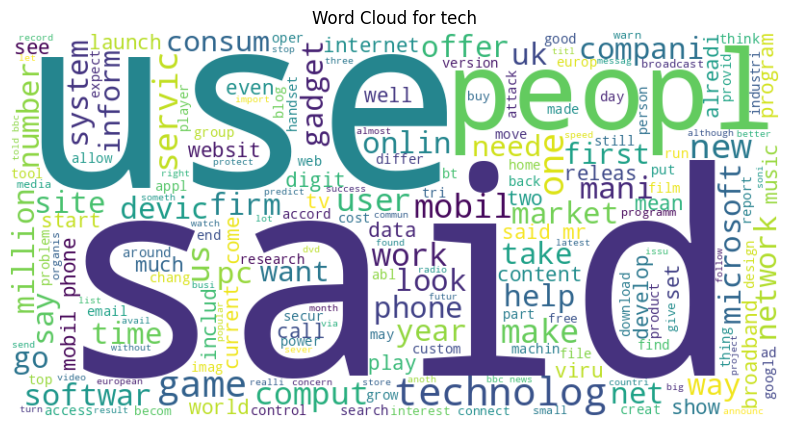

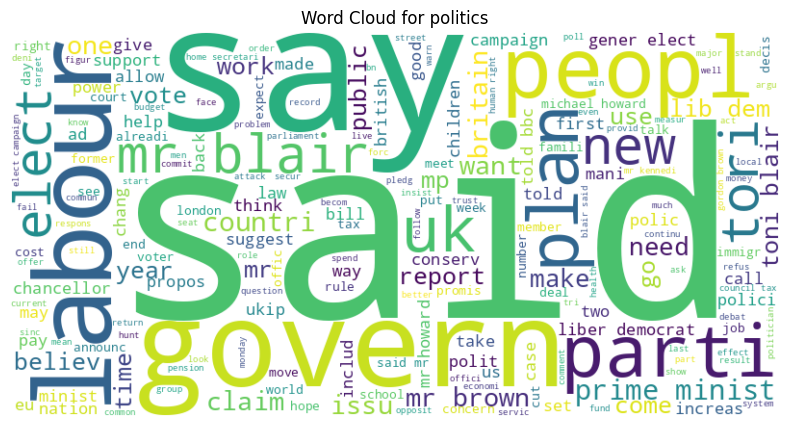

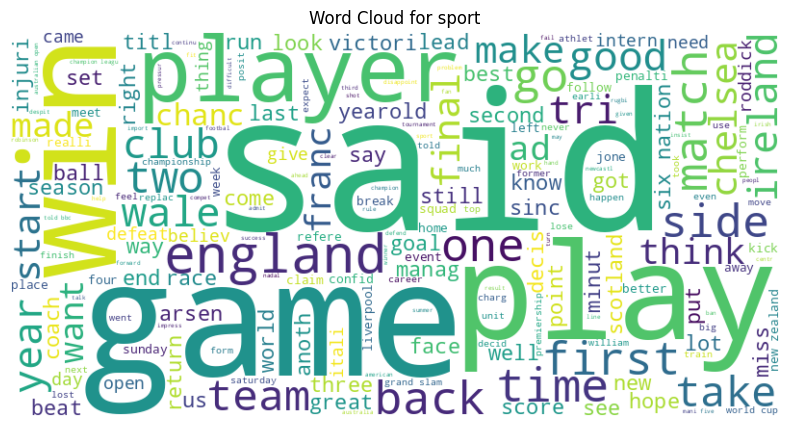

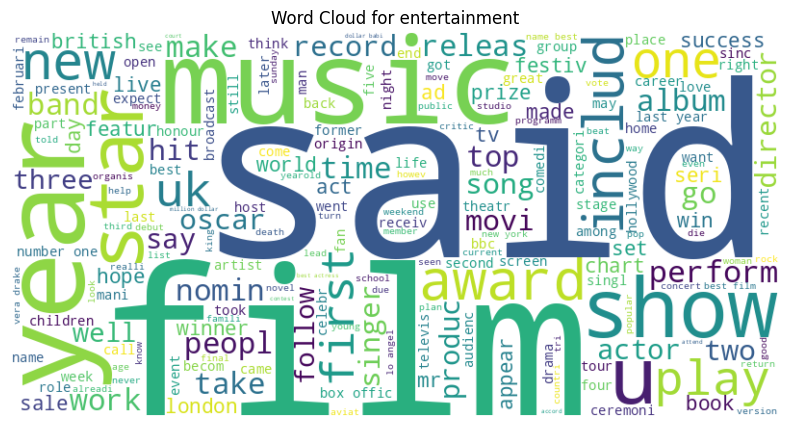

In [ ]:
# Generate a word cloud for each category
for category in df["Category"].unique():
    text = " ".join(
        df.loc[df["Category"] == category, "processed_text"]  # type: ignore
    )
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        text
    )

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

### Splitting the Dataset

Split the dataset into training and testing sets.


In [ ]:
X = df["processed_text"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Vectorization

Vectorize the preprocessed text data using TF-IDF vectorizer.


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to 1000 features
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

### Training and Evaluation

Define a function to train and evaluate a machine learning model using GridSearchCV to optimize parameters.


In [ ]:
def train_evaluate_model(
    model, param_grid, X_train, y_train, X_test, y_test, cv=5, scoring_metric="accuracy"
):
    """
    Trains and evaluates a machine learning model using GridSearchCV for hyperparameter tuning.

    Parameters:
    - model: The machine learning model to be trained.
    - param_grid: The parameter grid for hyperparameter tuning.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Testing data and labels.
    - cv: Number of cross-validation folds.
    - scoring_metric: Metric used for optimizing the model.
    """

    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring=scoring_metric, verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    print("Best parameters:", best_params)
    print(
        "Best cross-validation score: {:.2f}".format(grid_search.best_score_)
    )

    # Evaluate the best model
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Convert the set of labels to a sorted list
    labels = sorted(list(set(y_test)))

    # Plotting the confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return best_estimator, best_params, y_pred, y_test

### Logistic Regression Evaluation

Evaluate the Logistic Regression model with a hyperparameter tuning using GridSearchCV. This model is often effective for binary classification problems but can also be applied to multi-class scenarios. We will optimize the regularization strength (`C`) and the type of penalty to maximize model performance.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


198313.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
198313.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Users/jack.dalla.porta/.pyenv/versions/3.10.13/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /Users/jack.dalla.porta/.pyenv/versions/3.10.13/l

Best parameters: {'C': 100, 'penalty': 'l2'}
Best cross-validation score: 0.97

Classification Report:
                precision    recall  f1-score   support

     business       0.99      0.99      0.99        75
entertainment       0.96      0.98      0.97        46
     politics       0.93      0.95      0.94        56
        sport       0.97      1.00      0.98        63
         tech       1.00      0.93      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



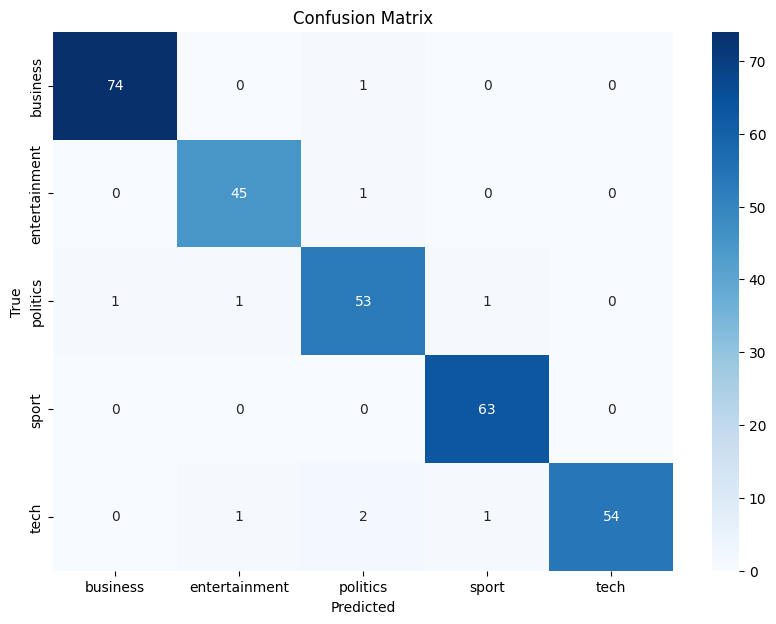

In [ ]:
param_grid = {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l2"]}

model_lreg, best_params_lreg, y_pred_lreg, y_test_lreg = train_evaluate_model(
    LogisticRegression(max_iter=1000),
    param_grid,
    X_train=X_train_vectors,
    y_train=y_train,
    X_test=X_test_vectors,
    y_test=y_test,
)

### SVM Evaluation

Evaluate the Support Vector Machine (SVM) model focusing on kernel types and regularization parameters. SVM is powerful for handling non-linear data through the use of different kernels. We will explore multiple kernel settings (linear, RBF, and polynomial) and gamma values to find the best configuration.


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97

Classification Report:
                precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       1.00      0.98      0.99        46
     politics       0.95      0.96      0.96        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.95      0.97        58

     accuracy                           0.97       298
    macro avg       0.98      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



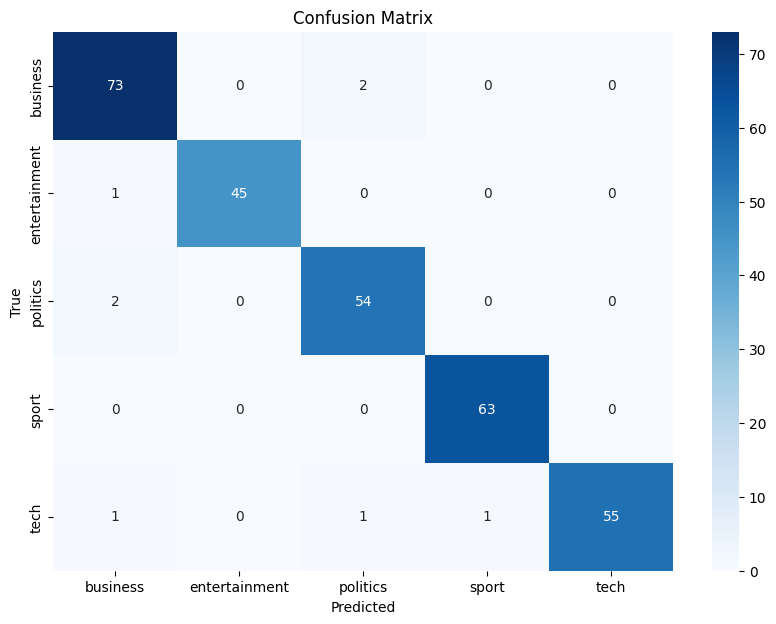

In [ ]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "poly", "sigmoid"],
}

model_svc, best_params_svc, y_pred_svc, y_test_svc = train_evaluate_model(
    SVC(),
    param_grid,
    X_train=X_train_vectors,
    y_train=y_train,
    X_test=X_test_vectors,
    y_test=y_test,
)

### Random Forest Evaluation

Evaluate the Random Forest Classifier, which is known for its robustness and ability to handle large datasets with higher dimensionality. We will tune parameters such as the number of trees (`n_estimators`), the depth of the trees (`max_depth`), and the minimum number of samples required to split an internal node (`min_samples_split`).


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.96

Classification Report:
                precision    recall  f1-score   support

     business       0.99      0.99      0.99        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.96      0.96        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.97      0.98        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



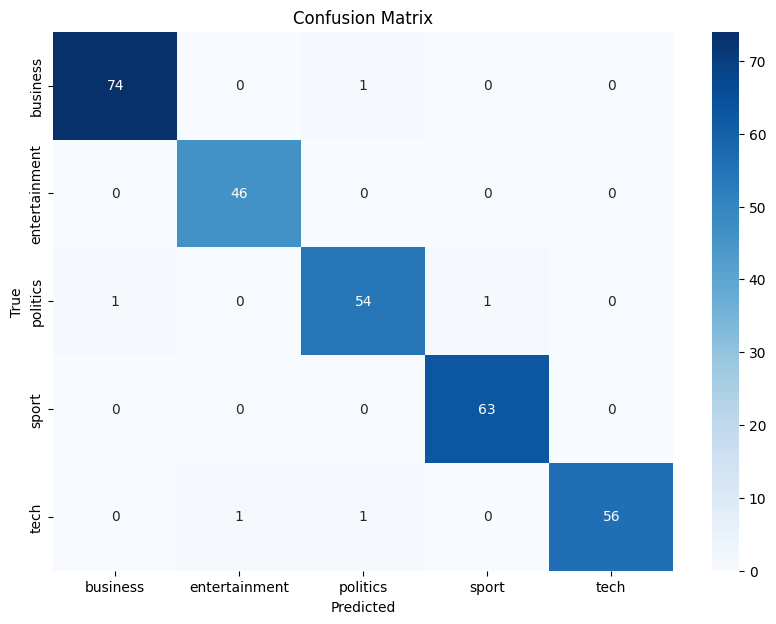

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

model_rfc, best_params_rfc, y_pred_rfc, y_test_rfc = train_evaluate_model(
    RandomForestClassifier(random_state=42),
    param_grid,
    X_train=X_train_vectors,
    y_train=y_train,
    X_test=X_test_vectors,
    y_test=y_test,
)

### Naive Bayes Evaluation

Evaluate the Multinomial Naive Bayes model, which is particularly suited for text classification tasks that involve frequency counts. We will optimize the smoothing parameter (`alpha`) to enhance model accuracy, especially given our dataset involves categorical text data.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 1}
Best cross-validation score: 0.96

Classification Report:
                precision    recall  f1-score   support

     business       0.97      0.99      0.98        75
entertainment       1.00      0.96      0.98        46
     politics       0.91      0.93      0.92        56
        sport       0.98      1.00      0.99        63
         tech       0.96      0.95      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.96      0.97       298
 weighted avg       0.97      0.97      0.97       298



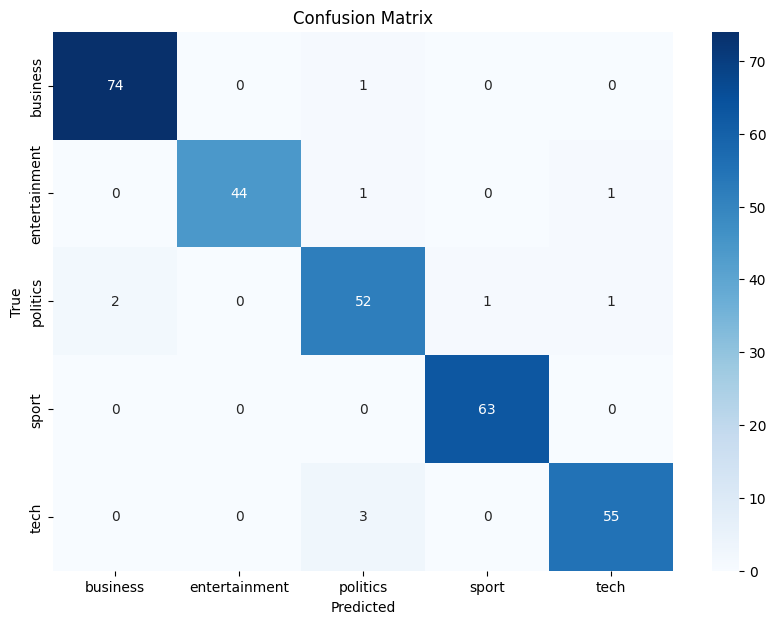

In [ ]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}


model_mnb, best_params_mnb, y_pred_mnb, y_test_mnb = train_evaluate_model(
    MultinomialNB(),
    param_grid,
    X_train=X_train_vectors,
    y_train=y_train,
    X_test=X_test_vectors,
    y_test=y_test,
)

### Visualizing the Distribution of News Categories

Visualize the distribution of news categories within the dataset to understand the balance of categories. This step includes printing the count of articles per category and displaying a bar chart that visually represents these counts. This visualization is crucial for identifying any imbalances that could affect model training and evaluation.


Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


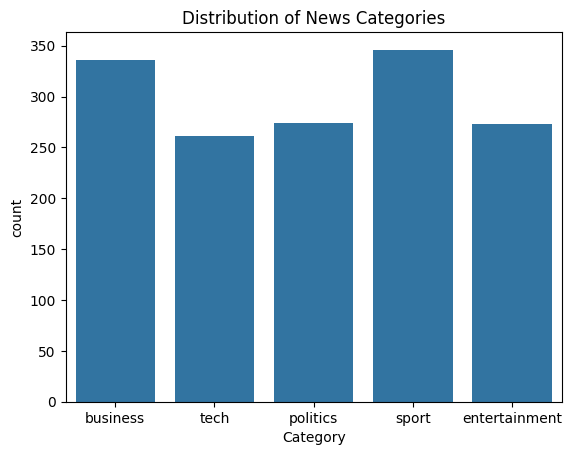

In [ ]:
# Print the distribution of categories
print(df["Category"].value_counts())

# Visualize the distribution using a seaborn count plot
sns.countplot(x="Category", data=df)
plt.title("Distribution of News Categories")
plt.show()

### Analyzing Language Bias with Sentiment Analysis

Perform sentiment analysis on the news articles to detect potential language biases. Using the VADER sentiment analyzer, each article is classified as 'Positive', 'Negative', or 'Neutral' based on its sentiment score. This analysis helps to understand the emotional tone across different news categories and assess whether certain categories might be more biased in terms of sentiment. The sentiment scores and their classifications could provide insights into the nature of language used in different types of news content.


In [ ]:

# Download the VADER lexicon for sentiment analysis
nltk.download("vader_lexicon")


# Define a function to analyze language bias based on sentiment intensity
def analyze_language_bias(text, threshold=0.4):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    # Classify the sentiment based on the compound score
    if sentiment_scores["compound"] >= threshold:
        return "Positive", sentiment_scores["compound"]
    elif sentiment_scores["compound"] <= -threshold:
        return "Negative", sentiment_scores["compound"]
    else:
        return "Neutral", sentiment_scores["compound"]


# Apply language bias analysis to the dataset
df["language_bias"], df["sentiment_score"] = zip(
    *df["Text"].apply(analyze_language_bias)
)

# Analyze and print the distribution of language biases
bias_counts = df["language_bias"].value_counts()
print("Language Bias Distribution:")
print(bias_counts)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jack.dalla.porta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Language Bias Distribution:
language_bias
Positive    1007
Negative     387
Neutral       96
Name: count, dtype: int64


### Define Categories and Initial Fairness Assessment

Define the categories used in the dataset and perform an initial fairness assessment using the F1-score from the classification report. This initial analysis helps identify any potential biases in the model's predictions across different news categories.


In [ ]:
categories = ["business", "entertainment", "politics", "sport", "tech"]
initial_bias_report = classification_report(
    y_test, y_pred_rfc, target_names=categories, output_dict=True
)

# Calculate the average F1 score and identify biased categories
initial_f1_scores = [
    initial_bias_report[category]["f1-score"] # type: ignore
    for category in categories
]
initial_avg_f1 = sum(initial_f1_scores) / len(initial_f1_scores)  # type: ignore
initial_biased_categories = [
    category
    for category in categories
    if initial_bias_report[category]["f1-score"] < initial_avg_f1 # type: ignore
]

print("\nInitial Fairness Metrics:\n", classification_report(
    y_test, y_pred_rfc, target_names=categories
))
print(
    f"\nInitially Biased Categories (F1-score < Average): {', '.join(initial_biased_categories)}"
)


Initial Fairness Metrics:
                precision    recall  f1-score   support

     business       0.99      0.99      0.99        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.96      0.96        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.97      0.98        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298


Initially Biased Categories (F1-score < Average): politics, tech


### Applying Bias Mitigation Technique - Resampling

Apply a resampling technique to balance the dataset and mitigate identified biases. Oversampling is used to increase the representation of underrepresented categories, aiming to reduce bias and improve model fairness.


In [ ]:
def balance_categories(X_train_vectors, y_train, categories):
    balanced_data = []
    balanced_labels = []
    oversampling_factor = 1.5

    for category in categories:
        category_mask = (y_train == category)
        category_data = X_train_vectors[category_mask]
        category_labels = y_train[category_mask]
        if category in initial_biased_categories:
            if hasattr(category_data, "shape"):
                n_samples = int(category_data.shape[0] * oversampling_factor)
            else:
                n_samples = int(category_data.nnz * oversampling_factor)
            oversampled_data, oversampled_labels = resample(
                category_data, category_labels, replace=True, n_samples=n_samples, random_state=42
            )

            balanced_data.append(oversampled_data)
            balanced_labels.append(oversampled_labels)
        else:
            balanced_data.append(category_data)
            balanced_labels.append(category_labels)

    X_train_balanced = vstack(balanced_data)
    y_train_balanced = np.hstack(balanced_labels)

    return X_train_balanced, y_train_balanced


X_train_balanced, y_train_balanced = balance_categories(
    X_train_vectors, y_train, categories
)

### Train Mitigated Model and Assess Post-Mitigation Fairness

Re-train the model using the balanced dataset and evaluate the fairness of the model after bias mitigation. This step includes re-assessing the F1-scores to see improvements in bias reduction.


In [ ]:
mitigated_rfc = RandomForestClassifier(random_state=42, **best_params_rfc)
mitigated_rfc.fit(X_train_balanced, y_train_balanced)  # type: ignore

y_pred_mitigated = mitigated_rfc.predict(X_test_vectors)
mitigated_bias_report = classification_report(
    y_test, y_pred_mitigated, target_names=categories, output_dict=True
)

# Identify biased categories in the mitigated model
mitigated_f1_scores = [
    mitigated_bias_report[category]["f1-score"]  # type: ignore
    for category in categories
]
mitigated_avg_f1 = sum(mitigated_f1_scores) / len(mitigated_f1_scores)  # type: ignore
mitigated_biased_categories = [
    category
    for category in categories
    if mitigated_bias_report[category]["f1-score"] < mitigated_avg_f1 # type: ignore
]

print("\nPost-Mitigation Fairness Metrics:\n", classification_report(
    y_test, y_pred_mitigated, target_names=categories
))
print(
    f"\nMitigated Biased Categories (F1-score < Average): {', '.join(mitigated_biased_categories)}"
)


Post-Mitigation Fairness Metrics:
                precision    recall  f1-score   support

     business       0.94      0.99      0.96        75
entertainment       0.98      0.98      0.98        46
     politics       0.96      0.96      0.96        56
        sport       1.00      1.00      1.00        63
         tech       1.00      0.93      0.96        58

     accuracy                           0.97       298
    macro avg       0.98      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298


Mitigated Biased Categories (F1-score < Average): business, politics, tech


### Visualize Fairness Metrics Comparison

Visualize the comparison of F1-scores before and after bias mitigation to clearly see the effects of the applied mitigation techniques.


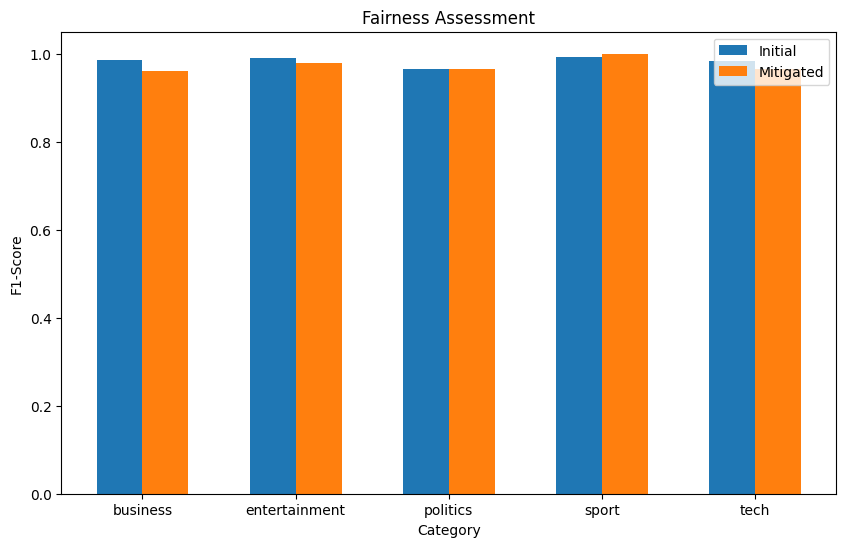

In [ ]:
plt.figure(figsize=(10, 6))
x = np.arange(len(categories))
bar_width = 0.30

plt.bar(
    x - bar_width/2,
    [initial_bias_report[cat]["f1-score"]  # type: ignore
     for cat in categories], bar_width, label='Initial'
)
plt.bar(
    x + bar_width/2,
    [mitigated_bias_report[cat]["f1-score"]  # type: ignore
     for cat in categories], bar_width, label='Mitigated'
)

plt.xlabel("Category")
plt.ylabel("F1-Score")
plt.title("Fairness Assessment")
plt.xticks(x, categories)
plt.legend()
plt.show()

### Visualizing Fairness Metrics After Mitigation

Visualize the fairness metrics by displaying the F1-scores for each category after applying bias mitigation techniques. This bar chart provides a clear and direct comparison of how well the model performs across different news categories, highlighting any remaining disparities in model accuracy and bias. This visualization helps in understanding the effectiveness of the bias mitigation steps and identifies areas that may still need improvement.


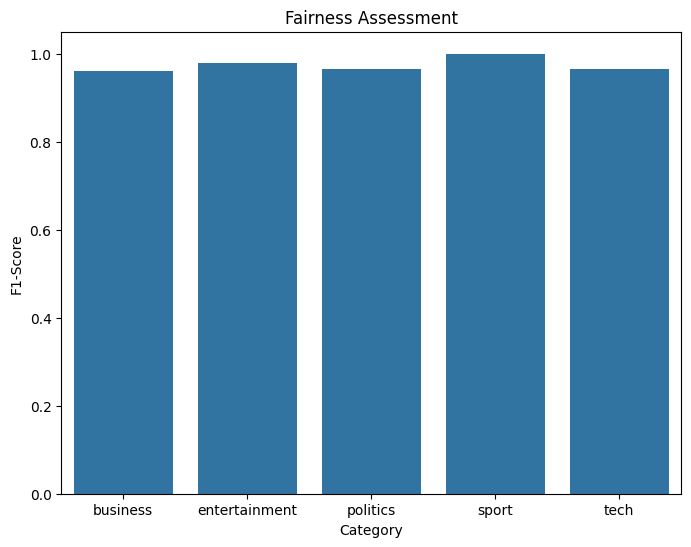

In [ ]:
# Set up the plot dimensions and style
plt.figure(figsize=(8, 6))

# Create a barplot to visualize the F1-scores for each category
sns.barplot(
    x=categories,
    y=[
        # Extract F1-scores from the mitigation report
        mitigated_bias_report[cat]["f1-score"] for cat in categories # type: ignore
    ]
)

# Set the labels and title for the plot
plt.xlabel("Category")
plt.ylabel("F1-Score")
plt.title("Fairness Assessment")
plt.show()